# Preprocessing Tutorial  
This tutorial focuses on how to utilize {mod}`dynamo` to preprocess data. In the new version, we make {class}`dynamo.pp.Preprocessor` class to allow you to freely explore different preprocessing recipes whose step parameters that can be configured inside {class}`dynamo.pp.Preprocessor`. Existing recipes in preprocessor includes monocle, pearson residual, seurat and sctransform. Moreover, you can replace each preprocessing step with your own implementation with ease. For instance, {class}`dynamo.pp.Preprocessor`'s monocle pipeline contains {meth}`dynamo.pp.filter_cells`, {meth}`dynamo.pp.filter_genes`, {meth}`dynamo.pp.normalize_cell_expr_by_size_factors`, {meth}`dynamo.pp.select_genes_by_pearson_residuals` and other steps. You can replace the implementation and default monocle parameters passed in to these functions by replacing or changing attributes of {class}`dynamo.pp.Preprocessor`.

In older versions, {mod}`dynamo` offer several recipes, among which {func}`dynamo.pp.recipe_monocle` is a basic function as a building block of other recipes. You can still use these functions to preprocess data.  

{class}`dynamo.pp.Preprocessor` provides users with {meth}`dynamo.pp.Preprocessor.config_monocle_recipe` and other `config_*_recipes` methods to help you reproduce different preprocessor results and integrate with your newly developed preprocessing algorithms.

Import packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

import dynamo as dyn

dyn.configuration.set_figure_params('dynamo', background='white')
dyn.pl.style(font_path='Arial')
dyn.get_all_dependencies_version()

%load_ext autoreload
%autoreload 2

Using already downloaded Arial font from: /tmp/dynamo_arial.ttf
Registered custom font as: Arial


 ███                               ████████        
█████   █████    █████    █████    ███   █████      
   ██████   ██████   ██████   ████████      ████ 
  ___                           ████            ███
 |   \ _  _ _ _  __ _ _ __  ___                 ███
 | |) | || | ' \/ _` | '  \/ _ \█████           ███ 
 |___/ \_, |_||_\__,_|_|_|_\___/█████       ████  
       |__/                        ███   █████     
Tutorial: https://dynamo-release.readthedocs.io/       
                                     █████      



package,umap-learn,typing-extensions,tqdm,statsmodels,setuptools,session-info,seaborn,scipy,requests,pynndescent,pre-commit,pandas,openpyxl,numdifftools,numba,networkx,mudata,matplotlib,loompy,leidenalg,igraph,dynamo-release,colorcet,anndata
version,0.5.7,4.13.2,4.67.1,0.14.4,79.0.0,1.0.1,0.13.2,1.11.4,2.32.3,0.5.13,4.2.0,2.2.3,3.1.5,0.9.41,0.60.0,3.4.2,0.3.1,3.10.3,3.0.8,0.10.2,0.11.8,1.4.2rc1,3.1.0,0.11.4


## Glossary of keys generated during preprocessing

**obs**
- `pass_basic_filter`: a list of boolean variables indicating whether cells pass certain basic filters. In monocle recipe, the basic filtering is based on thresholding of expression values.

**var**
- `pass_basic_filter`: a list of boolean variables indicating whether genes pass certain basic filters. In monocle recipe, the basic filtering is based on thresholding of expression values.
- `use_for_pca`: a list of boolean variables used during PCA dimension reduction and following downstream analysis. In many recipes, this key is equivalent to highly variable genes.
- `highly_variable_scores`: a list of float number scores indicating how variable each gene is, typically generated during gene feature selection (`preprocessor.select_genes`). Note only part of recipes do not have this highly variable scores. E.g. `seuratV3` recipe implemented in dynamo does not have highly variable scores due to its thresholding nature.

**layers**
- `X_spliced`: unspliced expression matrix after normalization used in downstream computation
- `X_unspliced`: spliced expression matrix after normalization used in downstream computation

**obsm**
- `X_pca`: normalized X after PCA transformation
  

## Using Predefined (default) Recipe Configurations in Preprocessor

Firstly, you can just start with the inclusion of a preprocessor, so that your life can become much easier. With just three lines of code, the preprocessor can handle the entire process of data filtering, manipulation, calculation, and conversion. You no longer have to worry about the headaches associated with these tasks.

In [15]:
adata = dyn.sample_data.zebrafish()
adata

|-----> Downloading data to ./data/zebrafish.h5ad
|-----> File ./data/zebrafish.h5ad already exists.


AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch'
    layers: 'spliced', 'unspliced'

Read zebrafish data

In [2]:
adata = dyn.sample_data.zebrafish()
celltype_key = "Cell_type"

|-----> Downloading data to ./data/zebrafish.h5ad
|-----> File ./data/zebrafish.h5ad already exists.


Import `Preprocessor` class

In [3]:
from dynamo.preprocessing import Preprocessor

{mod}`dynamo` provides users with {meth}`dynamo.pp.Preprocessor.preprocess_adata`, a simple wrapper, to apply preprocess steps with default settings. In this section, we will go through recipes in {meth}`dynamo.pp.Preprocessor.preprocess_adata` and observe how preprocess methods can influence visualization results.

### Applying Monocle Recipe 

In [4]:
preprocessor = Preprocessor()
preprocessor.preprocess_adata(adata, recipe="monocle")

# Alternative
# preprocessor.config_monocle_recipe(adata)
# preprocessor.preprocess_adata_monocle(adata)

default_preprocessor_monocle_adata = adata # save for usage later

|-----> Running monocle preprocessing pipeline...
|-----------> filtered out 14 outlier cells
|-----------> filtered out 12746 outlier genes
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> [Preprocessor-monocle] completed [3.4155s]


|-----> retrieve data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [UMAP] completed [0.0024s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering Cell_type by stack threshold when stacking color because it is not a numeric type


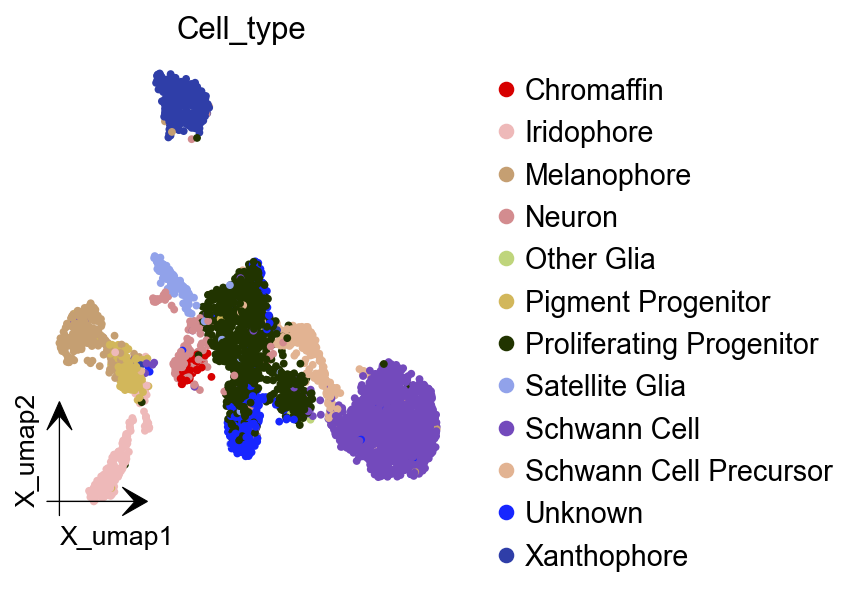

In [19]:
dyn.tl.reduceDimension(adata, basis="pca")
dyn.pl.umap(adata, color=celltype_key, figsize=(4,4),pointsize=0.05,alpha=1,
           adjust_legend=True,arrow_scale=8,show_legend='upper right')

### Applying Pearson Residuals Recipe

Please note that pearson residual or sctransform transformation should only be performed for adata.X and not applied to different layers. This is because RNA velocity do have physical meanings, and otherwise spliced/unspliced data will reseult in negative values after transformation.

In [20]:
adata = dyn.sample_data.zebrafish()
preprocessor = Preprocessor()
# preprocessor.config_pearson_residuals_recipe(adata)
# preprocessor.preprocess_adata_pearson_residuals(adata)
preprocessor.preprocess_adata(adata, recipe="pearson_residuals")

|-----> Downloading data to ./data/zebrafish.h5ad
|-----> File ./data/zebrafish.h5ad already exists.
|-----> gene selection on layer: X
|-----> extracting highly variable genes
|-----------> filtered out 350 outlier genes
|-----> applying Pearson residuals to layer <X>
|-----> replacing layer <X> with pearson residual normalized data.
|-----> [pearson residual normalization for X] completed [1.1498s]
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> [Preprocessor-pearson residual] completed [6.4230s]


|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [11.4033s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering Cell_type by stack threshold when stacking color because it is not a numeric type


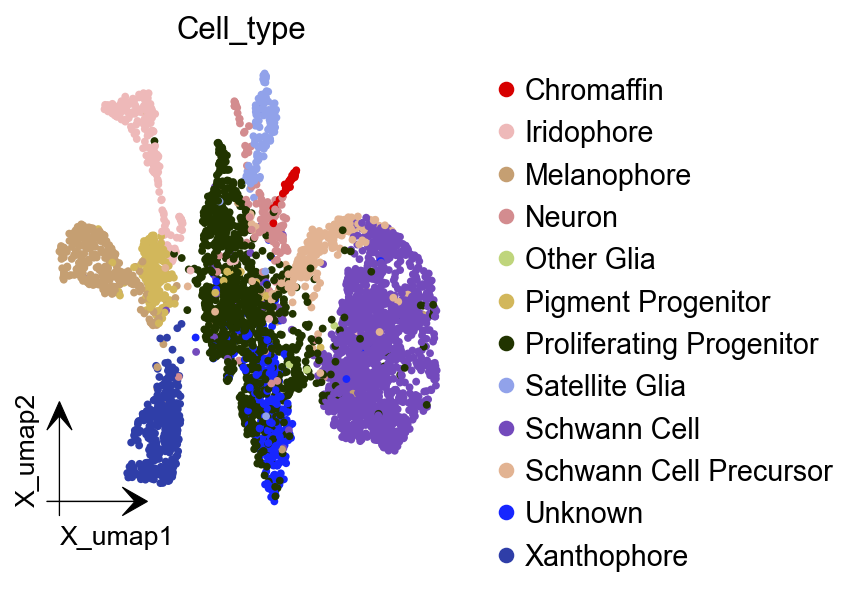

In [21]:
dyn.tl.reduceDimension(adata)
dyn.pl.umap(adata, color=celltype_key, figsize=(4,4),pointsize=0.05,alpha=1,
           adjust_legend=True,arrow_scale=8,show_legend='upper right')

### Applying Sctransform Recipe

Here, you need to install the [`KDEpy`](https://kdepy.readthedocs.io/en/latest/) before to run `sctransform`. you can use `pip install KDEpy` to install it.

Sctransform transformation is only applied to adata.X and not applied to different layers, as stated above.

In [25]:
adata = dyn.sample_data.zebrafish()
preprocessor = Preprocessor()
# preprocessor.config_sctransform_recipe(adata)
# preprocessor.preprocess_adata_sctransform(adata)
preprocessor.preprocess_adata(adata, recipe="sctransform")

|-----> Downloading data to ./data/zebrafish.h5ad
|-----> File ./data/zebrafish.h5ad already exists.
|-----> Running Sctransform recipe preprocessing...
|-----------> filtered out 14 outlier cells
|-----------> filtered out 12410 outlier genes
|-----? Sctransform recipe will subset the data first with default gene selection function for efficiency. If you want to disable this, please perform sctransform without recipe.
|-----> sctransform adata on layer: X
|-----------> set sctransform results to adata.X
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> [Preprocessor-sctransform] completed [15.9547s]


|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [11.4976s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering Cell_type by stack threshold when stacking color because it is not a numeric type


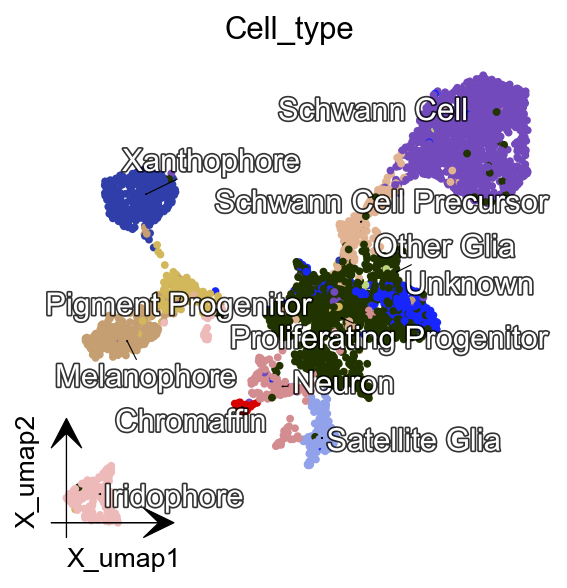

In [26]:
dyn.tl.reduceDimension(adata)
dyn.pl.umap(adata, color=celltype_key, figsize=(4,4),pointsize=0.05,alpha=1,
           adjust_legend=True,arrow_scale=8)

### Applying Seurat Recipe

In [27]:
adata = dyn.sample_data.zebrafish()
preprocessor = Preprocessor()
# preprocessor.config_seurat_recipe()
# preprocessor.preprocess_adata_seurat(adata)
preprocessor.preprocess_adata(adata, recipe="seurat")

|-----> Downloading data to ./data/zebrafish.h5ad
|-----> File ./data/zebrafish.h5ad already exists.
|-----> Running Seurat recipe preprocessing...
|-----------> filtered out 14 outlier cells
|-----------> filtered out 11388 outlier genes
|-----> select genes on var key: pass_basic_filter
|-----------> choose 2000 top genes
|-----> number of selected highly variable genes: 2000
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> [Preprocessor-seurat] completed [1.5014s]


|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [11.4430s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering Cell_type by stack threshold when stacking color because it is not a numeric type


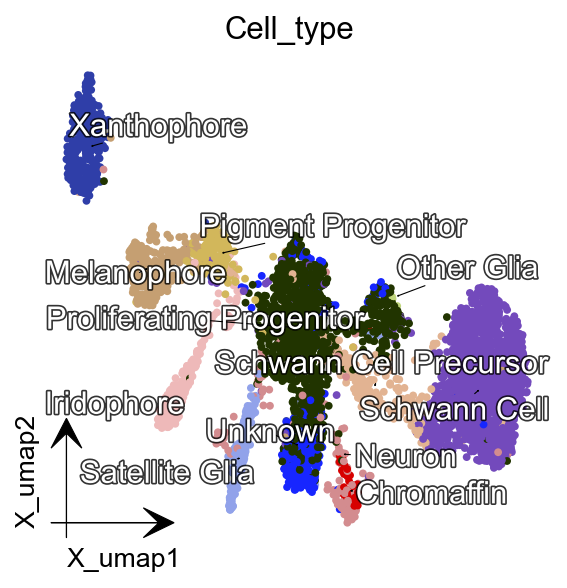

In [28]:
dyn.tl.reduceDimension(adata)
dyn.pl.umap(adata, color=celltype_key, figsize=(4,4),pointsize=0.05,alpha=1,
           adjust_legend=True,arrow_scale=8)

## Customize Function Parameters Configured in Preprocessor
Here we are gong to use recipe monocle as an example. In recipe monocle's selection genes function, we can set recipe to be `dynamo_monocle`, `seurat`, `svr` and others to apply different criterions to select genes. We can set preprocesor's `select_genes_kwargs` to pass wanted parameters. In the example below, the default parameter is `recipe=dynmoa_monocle`. We can change it to `seurat` and add other contraint parameters as well.

Let's call {meth}`dynamo.pp.Preprocessor.config_monocle_recipe` to set `monocle` recipe preprocessing steps and corresponding function parameters. The default constructor parameters of {class}`dynamo.pp.Preprocessor` for preprocessing are from our monocle recipe used in {mod}`dynamo` papers.

In [29]:
adata = dyn.sample_data.zebrafish()
preprocessor = Preprocessor()
preprocessor.config_monocle_recipe(adata)

|-----> Downloading data to ./data/zebrafish.h5ad
|-----> File ./data/zebrafish.h5ad already exists.


`preprocessor.select_genes_kwargs` contains arguments that will be passed to {meth}`dynamo.pp.Preprocessor.select_genes` step.

In [30]:
preprocessor.select_genes_kwargs

{'n_top_genes': 2000, 'SVRs_kwargs': {'relative_expr': False}}

To set the preprocessing steps and their corresponding function parameters for the monocle recipe, we can call {meth}`dynamo.pp.Preprocessor.config_monocle_recipe`. By default, the constructor parameters of the Preprocessor for preprocessing are set to the monocle recipe used in report the Dynamo cell paper dynamo.

If you would like to customize the dataset to better fit your preferences, you can adjust the parameters before running the recipe. Here is an example.

To begin, you can create a plot of the basic statistics (nGenes, nCounts, and pMito) for each category of adata. - nGenes: the number of genes - nCounts: the number of cells - pMito: the percentage of mitochondria genes.

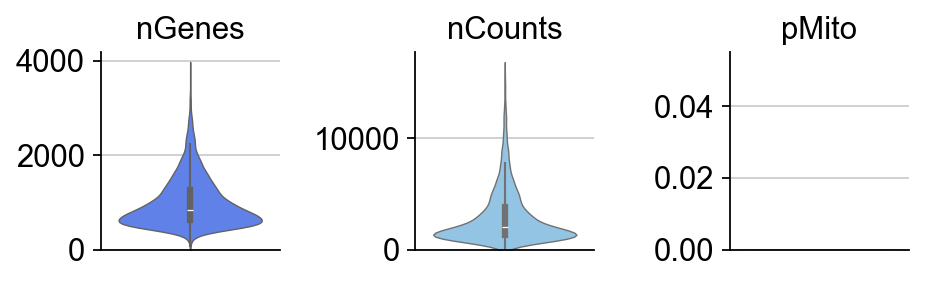

In [34]:
dyn.pl.basic_stats(adata, figsize=(2, 2))

You can visualize the rank of the fraction of UMI to the total UMI per cell for the top 20 genes

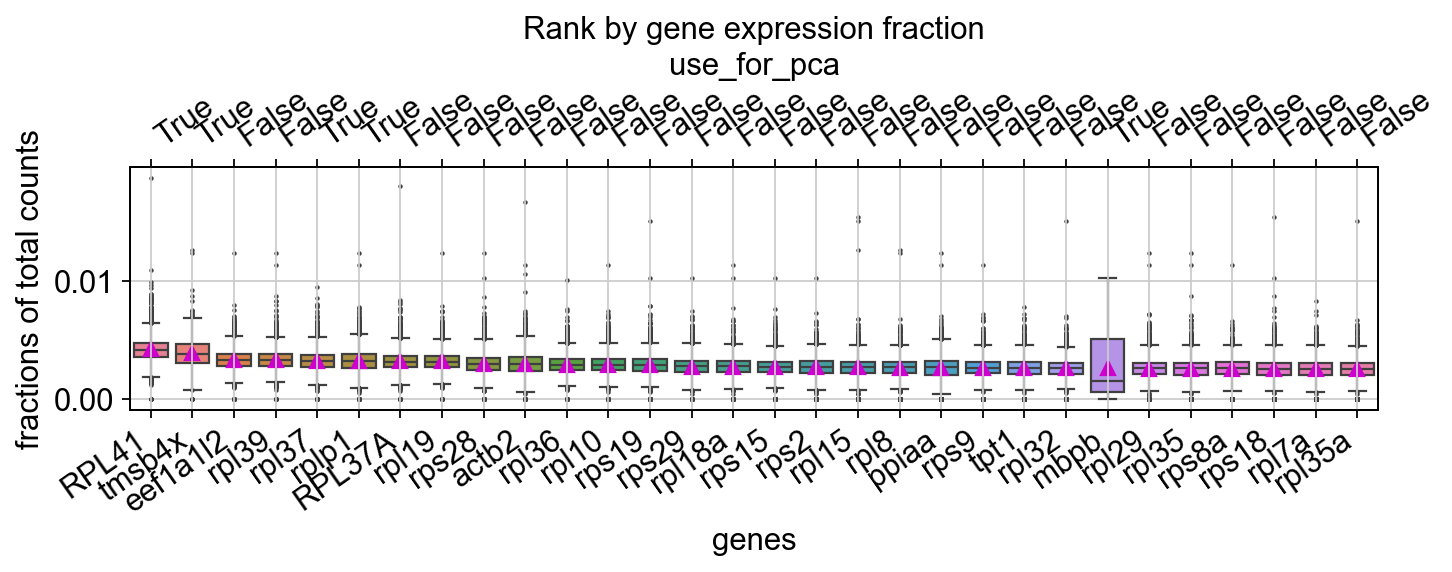

<Axes: title={'center': 'Rank by gene expression fraction'}, xlabel='genes', ylabel='fractions of total counts'>

In [37]:
dyn.pl.highest_frac_genes(adata, figsize=(10, 2))

You can get rid of any cells that have mitochondrial gene expression percentage greater than pMito or total counts greater than nCounts. You can adjust the threshold values as per your requirements.

Note that in our particular case, our data doesn’t have mitochondria counts.

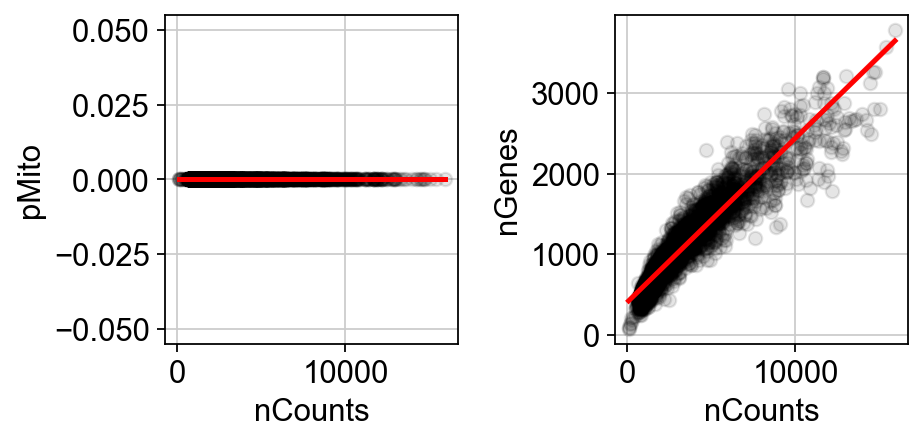

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the first figure
df = adata.obs.loc[:, ["nCounts", "pMito", "nGenes"]]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))  # Adjust the figsize as desired

sns.regplot(data=df,
            x="nCounts",
            y="pMito",
            ax=ax1,
            scatter_kws={"color": "black",  "alpha": 0.1},
            line_kws={"color": "red"})
ax1.set_xlabel("nCounts")
ax1.set_ylabel("pMito")

# Create the second figure
sns.regplot(data=df,
            x="nCounts",
            y="nGenes",
            ax=ax2,
            scatter_kws={"color": "black",  "alpha": 0.1},
            line_kws={"color": "red"})
ax2.set_xlabel("nCounts")
ax2.set_ylabel("nGenes")

# Display the figures side by side
plt.tight_layout()  # Optional: Adjusts spacing between subplots

And modify some values of parameters based on the information above.

In [40]:
import numpy as np
preprocessor.filter_cells_by_outliers_kwargs = {
    "filter_bool": None,
    "layer": "all",
    "min_expr_genes_s": 300,
    "min_expr_genes_u": 100,
    "min_expr_genes_p": 50,
    "max_expr_genes_s": np.inf,
    "max_expr_genes_u": np.inf,
    "max_expr_genes_p": np.inf,
    "shared_count": None,
}

In [41]:
preprocessor.filter_genes_by_outliers_kwargs = {
    "filter_bool": None,
    "layer": "all",
    "min_cell_s": 3,
    "min_cell_u": 2,
    "min_cell_p": 1,
    "min_avg_exp_s": 0,
    "min_avg_exp_u": 0,
    "min_avg_exp_p": 0,
    "max_avg_exp": np.inf,
    "min_count_s": 5,
    "min_count_u": 0,
    "min_count_p": 0,
    "shared_count": 40,
}

In [42]:
preprocessor.select_genes_kwargs = {
    "n_top_genes": 2500,
    "sort_by": "cv_dispersion",
    "keep_filtered": True,
    "SVRs_kwargs": {
        "relative_expr": True,
        "total_szfactor": "total_Size_Factor",
        "min_expr_cells": 0,
        "min_expr_avg": 0,
        "max_expr_avg": np.inf,
        "winsorize": False,
        "winsor_perc": (1, 99.5),
        "sort_inverse": False,
        "svr_gamma": None,
    },
}

|-----> Running monocle preprocessing pipeline...
|-----------> filtered out 111 outlier cells
|-----------> filtered out 13042 outlier genes
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> [Preprocessor-monocle] completed [1.4155s]
|-----> retrieve data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [UMAP] completed [0.0016s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering Cell_type by stack threshold when stacking color because it is not a numeric type


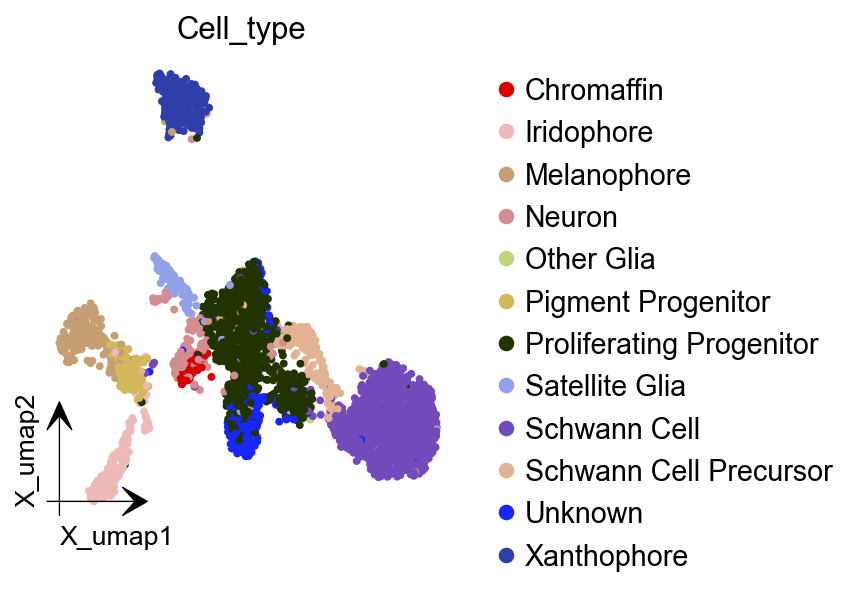

In [43]:
preprocessor.preprocess_adata_monocle(adata);
dyn.tl.reduceDimension(adata)
dyn.pl.umap(adata, color=celltype_key, figsize=(4,4),pointsize=0.05,alpha=1,
           adjust_legend=True,arrow_scale=8,show_legend='upper right')

## Customize and run each functions directly.

We understand that some of you may prefer to use the each function by calling your own customized parameters. To cater to these needs, we have prepared the following guidances help you utilizing the conventional steps with our new preprocessor class. This way, you can still take advantage of the benefits of the preprocessor while also incorporating your own specific requirements.



In [44]:
pp = Preprocessor()
adata = dyn.sample_data.zebrafish()
pp.standardize_adata(adata, 'time', None)

|-----> Downloading data to ./data/zebrafish.h5ad
|-----> File ./data/zebrafish.h5ad already exists.


In [45]:
pp.filter_cells_by_outliers(adata, max_expr_genes_s=2000)

|-----------> filtered out 244 outlier cells


AnnData object with n_obs × n_vars = 3937 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter'
    var: 'nCells', 'nCounts'
    uns: 'pp'
    layers: 'spliced', 'unspliced'

In [46]:
pp.filter_genes_by_outliers(adata, max_avg_exp=2000, shared_count=40)

|-----------> filtered out 13890 outlier genes


tmsb4x         True
rpl8           True
ppiaa          True
rpl10a         True
rps4x          True
              ...  
cdc42ep1a     False
camk1da       False
zdhhc22       False
zgc:153681    False
mmp16b        False
Name: pass_basic_filter, Length: 16940, dtype: bool

In [47]:
pp.normalize_by_cells(adata)

AnnData object with n_obs × n_vars = 3937 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size'
    var: 'nCells', 'nCounts', 'pass_basic_filter'
    uns: 'pp'
    layers: 'spliced', 'unspliced', 'X_spliced', 'X_unspliced'

In [48]:
pp.select_genes(adata, sort_by="fano_dispersion") # "cv_dispersion" or "gini"

In [49]:
pp.norm_method(adata) # log1p

AnnData object with n_obs × n_vars = 3937 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'log_m', 'log_cv', 'frac', 'use_for_pca'
    uns: 'pp', 'velocyto_SVR', 'feature_selection'
    layers: 'spliced', 'unspliced', 'X_spliced', 'X_unspliced'

In [50]:
pp.pca(adata)

|-----> <insert> X_pca to obsm in AnnData Object.


AnnData object with n_obs × n_vars = 3937 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'log_m', 'log_cv', 'frac', 'use_for_pca'
    uns: 'pp', 'velocyto_SVR', 'feature_selection', 'PCs', 'explained_variance_ratio_', 'pca_mean'
    obsm: 'X_pca'
    layers: 'spliced', 'unspliced', 'X_spliced', 'X_unspliced'

|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [25.5451s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering Cell_type by stack threshold when stacking color because it is not a numeric type


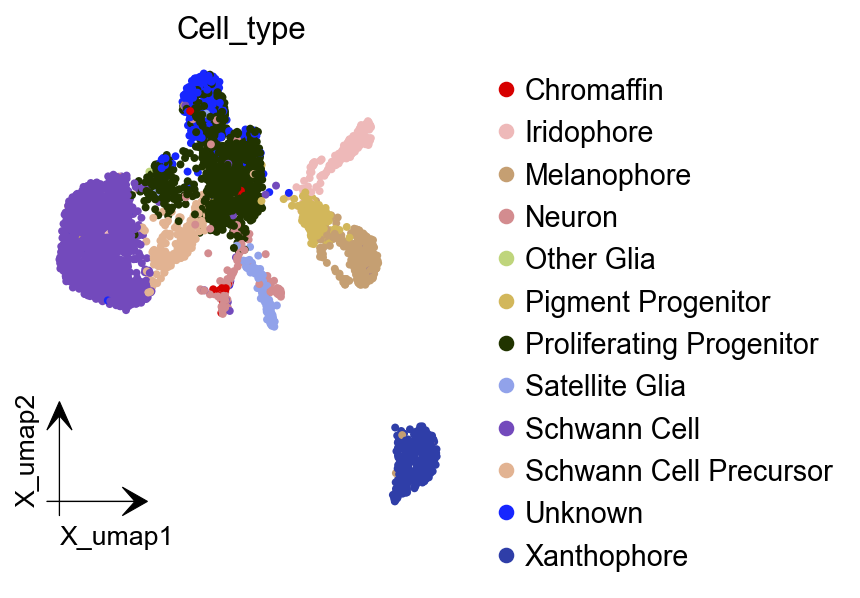

In [51]:
dyn.tl.reduceDimension(adata,basis='pca')
dyn.pl.umap(adata, color=celltype_key, figsize=(4,4),pointsize=0.05,alpha=1,
           adjust_legend=True,arrow_scale=8,show_legend='upper right')